In [250]:
import numpy as np 
import torch
import matplotlib.pyplot as plt
from imageio import imread, imwrite
from torch import nn
import random
import PIL.Image as Image
import torch.nn as nn

In [217]:
import sys
sys.path.append("..")
# from steganogan.decoders import DenseDecoderNLayers
from steganogan.decoders import BasicDecoder, DenseDecoder, DenseDecoderNLayers
from steganogan import SteganoGAN

In [218]:
import torch
import torchvision

In [219]:
from tqdm import tqdm, trange

In [254]:
def shuffle_params(m):
    if type(m)==nn.Conv2d or type(m)==nn.BatchNorm2d:
        param = m.weight
        m.weight.data = nn.Parameter(torch.tensor(np.random.normal(0, 1, param.shape)).float())
        
        param = m.bias
        m.bias.data = nn.Parameter(torch.zeros(len(param.view(-1))).float().reshape(param.shape))

def kaming_params(m):
    if type(m)==nn.Conv2d or type(m)==nn.BatchNorm2d:
        nn.init.kaiming_uniform_(m.weight.data, mode='fan_in', nonlinearity='relu')
#         nn.init.kaiming_uniform_(m.bias.data, mode='fan_in', nonlinearity='relu')

#         

In [255]:
class BasicDecoder(nn.Module):
    """
    The BasicDecoder module takes an steganographic image and attempts to decode
    the embedded data tensor.

    Input: (N, 3, H, W)
    Output: (N, D, H, W)
    """

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )

    def _build_models(self):
        self.layers = nn.Sequential(
            self._conv2d(3, self.hidden_size),
            nn.LeakyReLU(inplace=True),
#             nn.BatchNorm2d(self.hidden_size),
#             nn.LayerNorm([self.hidden_size,450,612]),

            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
#             nn.BatchNorm2d(self.hidden_size),
#             nn.LayerNorm([self.hidden_size,450,612]),

            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
#             nn.BatchNorm2d(self.hidden_size),
#                         nn.LayerNorm([self.hidden_size,450,612]),


            self._conv2d(self.hidden_size, self.data_depth)
        )

        return [self.layers]

    def __init__(self, data_depth, hidden_size):
        super().__init__()
        self.version = '1'
        self.data_depth = data_depth
        self.hidden_size = hidden_size

        self._models = self._build_models()

    def upgrade_legacy(self):
        """Transform legacy pretrained models to make them usable with new code versions."""
        # Transform to version 1
        if not hasattr(self, 'version'):
            self._models = [self.layers]

            self.version = '1'

    def forward(self, x):
        x = self._models[0](x)

        if len(self._models) > 1:
            x_list = [x]
            for layer in self._models[1:]:
                x = layer(torch.cat(x_list, dim=1))
                x_list.append(x)

        return x

In [261]:
# models
model_name = "steg_decode_new"
if model_name == "steg_decode":
#     steganogan = SteganoGAN.load(architecture='dense', path=None, cuda=True, verbose=True)
    steganogan = SteganoGAN.load(path="demo_1.1.steg", cuda=True, verbose=True)
    model = steganogan.decoder
    model.apply(shuffle_params)
elif model_name == "steg_decode_new":
    model = BasicDecoder(1, hidden_size=32)
#     model.apply(shuffle_params)
    model.apply(kaming_params)
    model.to('cuda')
else:
    print("unknown model")

model.to('cuda')
# def total_variation_loss(img, weight):
#     bs_img, c_img, h_img, w_img = img.size()
#     tv_h = torch.abs(img[:,:,1:,:]-img[:,:,:-1,:]).sum()
#     tv_w = torch.abs(img[:,:,:,1:]-img[:,:,:,:-1]).sum()
#     return weight*(tv_h+tv_w)/(bs_img*c_img*h_img*w_img)

BasicDecoder(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01, inplace)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01, inplace)
    (6): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [262]:
# extract a bit vector
image = "/home/vk352/FaceDetection/datasets/sample/obama2.jpg"
image = imread(image, pilmode='RGB') / 255.0
image = torch.FloatTensor(image).permute(2, 1, 0).unsqueeze(0)
image = image.to('cuda')
out = model(image)
# image = self.decoder(image).view(-1) > 0

In [263]:
target = torch.bernoulli(torch.empty(out.shape).uniform_(0, 1)).to(out.device)
target.shape

torch.Size([1, 1, 450, 612])

In [264]:
# pgd attack
steps = 1000
eps=0.2
alpha=2/255
adv_image = image.clone().detach()

hinge = 0.3

criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

# criterion = torch.nn.HingeEmbeddingLoss(margin=1, reduction='sum')
# target = target * 2 - 1
accuracy = []
model.train()
for i in range(steps):
    adv_image.requires_grad = True
    outputs = model(adv_image)
    
#     outputs = outputs
    
#     loss = criterion(outputs, target)+ total_variation_loss(adv_image, 10)
    loss = criterion(outputs, target)
#     loss = -(target * 2 - 1) * outputs
#     loss = torch.nn.functional.softplus(loss)  # log(1+exp(x))
#     loss = torch.max(loss-hinge, torch.zeros(target.shape).to(target.device))
#     loss = torch.sum(loss)

# #     loss = torch.sum(torch.max(torch.zeros(target.shape).to(target.device), 1 - (target * 2 - 1) * outputs))
# #     loss = torch.exp(loss / 10)
# #     loss = 0#torch.sum(torch.max(torch.zeros(target.shape).to(target.device), 0.5 - target * outputs))
#     loss = torch.sum(loss)
#     print(loss)

    grad = torch.autograd.grad(loss, adv_image, retain_graph=False, create_graph=False)[0]

    adv_image = adv_image.detach() - alpha*grad.sign()
    delta = torch.clamp(adv_image - image, min=-eps, max=eps)
    adv_image = torch.clamp(image + delta, min=0, max=1).detach()
#     adv_image = torch.clamp(adv_image*255, 0, 255).int()
#     np_data = adv_image.cpu().data.numpy().astype(np.uint8)[0].transpose([1,2,0])
#     img_data = Image.fromarray(np_data)
#     img_data.save('tmp.jpg')
#     np_data = np.array(Image.open('tmp.jpg'))/255.
#     adv_image = torch.from_numpy(np_data).float().permute(2,0,1)[None].to('cuda')
    
    accuracy.append(len(torch.nonzero((model(adv_image)>0).float().view(-1) != target.view(-1))) / target.numel())
#     print(accuracy[-1])
    
# bceacc = accuracy
# logacc = accuracy
# hingelogacc[hinge] = accuracy
# hingeacc = accuracy
# print(accuracy)

In [260]:
len(torch.nonzero((model(adv_image)>0).float().view(-1) != target.view(-1))) / target.numel()

0.2547421931735657

In [243]:
# adv_image = torch.clamp(adv_image*255, 0, 255).int()
# np_data = adv_image.cpu().data.numpy().astype(np.uint8)[0].transpose([1,2,0])
# img_data = Image.fromarray(np_data)
# img_data.save('tmp.jpg')
# np_data = np.array(Image.open('tmp.jpg'))/255.
# adv_image = torch.from_numpy(np_data).float().permute(2,0,1)[None].to('cuda')

In [242]:
len(torch.nonzero((model(adv_image)>0).float().view(-1) != target.view(-1))) / target.numel()

0.3581408859840232

In [201]:
train_model2 = accuracy

In [190]:
train_model1 = accuracy

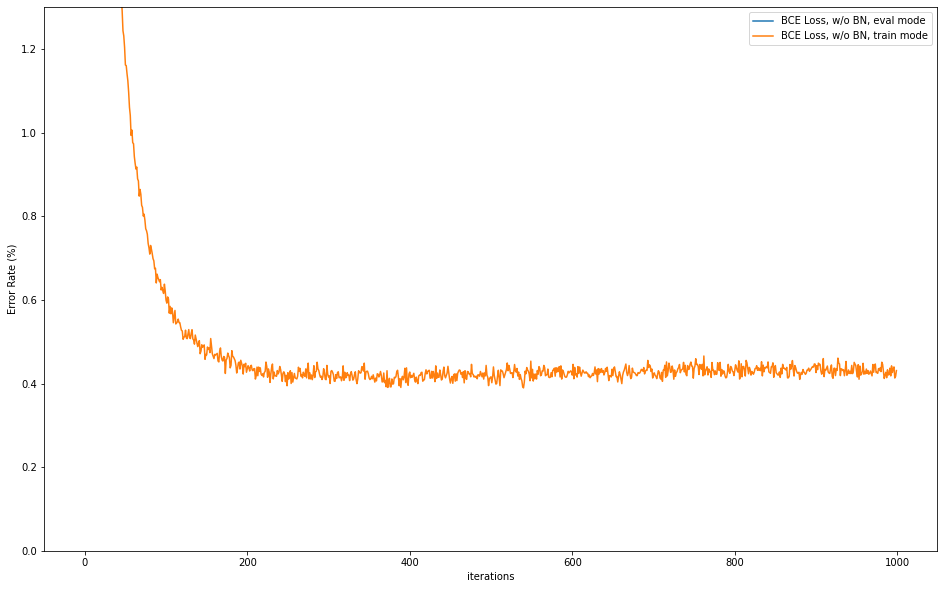

In [249]:
plt.figure(figsize=(16, 10))
# plt.plot(range(1000), np.array(bceacc) * 100, label="BCE Loss")
plt.plot(range(1000), np.array(accuracy) * 100, label="BCE Loss, w/o BN, eval mode")
plt.plot(range(1000), np.array(train_model2) * 100, label="BCE Loss, w/o BN, train mode")

# plt.plot(range(1000), np.array(accs['bceacc']) * 100, label="BCE Loss, with BatchNorm")

# plt.plot(range(1000), np.array(hingeacc) * 100, label="Hinge Loss")
# for hin, acc in hingelogacc.items():
#     if hin < 0.5:
#         plt.plot(range(1000), np.array(acc) * 100, label=f"Hinge Log Loss {hin}")
plt.legend()
plt.ylabel("Error Rate (%)")
plt.xlabel("iterations")
plt.ylim(0, 1.3)
plt.show()

In [161]:
output = (model(adv_image)>0)
# output = (out>0)

In [ ]:
print("Number of Incorrect bits:")
print(len(torch.nonzero(output.float().view(-1) != target.view(-1))))
print("Total bits:")
print(target.numel())
print("Error rate:")
print(len(torch.nonzero(output.float().view(-1) != target.view(-1))) / target.numel())

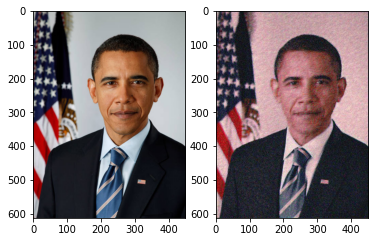

In [176]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(image.cpu().squeeze().permute(2,1,0))
axs[1].imshow(adv_image.cpu().squeeze().permute(2,1,0))

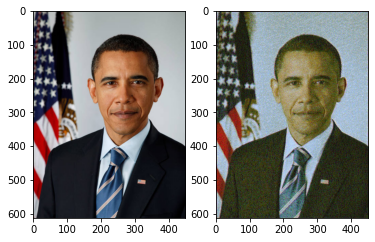

In [162]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(image.cpu().squeeze().permute(2,1,0))
axs[1].imshow(adv_image.cpu().squeeze().permute(2,1,0))

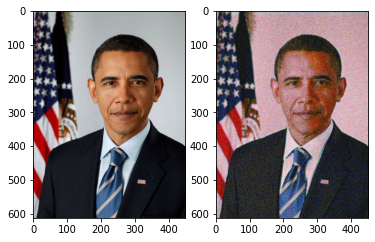

In [127]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(image.cpu().squeeze().permute(2,1,0))
axs[1].imshow(adv_image.cpu().squeeze().permute(2,1,0))

In [ ]:
# np.save('hinge_03_layernorm.npy', np.array(accuracy))

In [55]:
# np.save('bec_sum_layernorm.npy', np.array(accuracy))

In [25]:
import pickle
with open("accs.pkl", "rb") as f:
    accs = pickle.load(f)

In [ ]:
accs['hingelogacc'][0.3]

In [27]:
accs['bceacc']

[0.42302832244008715,
 0.3881917211328976,
 0.35188453159041394,
 0.3218591140159768,
 0.2935257806826434,
 0.26921205519244734,
 0.2468554829339143,
 0.2267029774872912,
 0.2081517792302106,
 0.19207334785766159,
 0.17696441539578794,
 0.16383079157588962,
 0.15135802469135803,
 0.14100217864923748,
 0.13018518518518518,
 0.12276688453159042,
 0.11348583877995642,
 0.10611837327523602,
 0.09895424836601308,
 0.09249818445896878,
 0.08647421931735658,
 0.08116920842411038,
 0.07516702977487291,
 0.07038126361655773,
 0.065279593318809,
 0.062175018155410315,
 0.0577196804647785,
 0.05472040668119099,
 0.05052287581699346,
 0.048090050835148876,
 0.04492737835875091,
 0.04226579520697168,
 0.03970951343500363,
 0.037650689905591866,
 0.03543572984749455,
 0.0330319535221496,
 0.031190994916485113,
 0.029121278140885984,
 0.027814088598402325,
 0.026176470588235294,
 0.02466957153231663,
 0.023198983297022514,
 0.02185911401597676,
 0.020893246187363834,
 0.01961510530137981,
 0.01871096